In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, Callback, TensorBoard,  History

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline


Using TensorFlow backend.


In [2]:
# 准备数据
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

X_train = train.drop('label', axis=1)
Y_train = train['label']

print(train.shape)
print(X_train.shape)
# Y_train.value_counts()

(42000, 785)
(42000, 784)


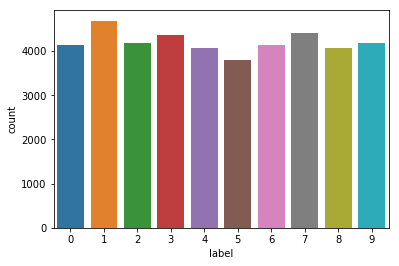

In [3]:
# 直方图
y_ax = sns.countplot(Y_train)

In [4]:
#归一化
def normalize(x):
    X_normale = (x-np.min(x))/(np.max(x)-np.min(x))
    return X_normale

# or
def normalize1(x):
    X_normale = x/255.
    return X_normale


X_train = normalize(X_train.values)
test = normalize(test.values)

# image 28*28*1
X_train = X_train.reshape(-1,28,28,1)
test = test.reshape(-1,28,28,1)
print(X_train.shape)

(42000, 28, 28, 1)


In [5]:
#  one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [6]:
# 数据集划分
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.05, random_state=42)

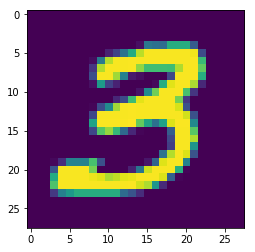

In [7]:
plt.imshow(X_train[1][:,:,0])

In [8]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
        
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
        
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [9]:
# SCNN model 
# In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

# input: 28x28 images with 1 channels -> (28, 28, 1) tensors.
model.add(Conv2D(filters = 32, kernel_size = (4,4), padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (4,4), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [10]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [11]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [12]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=0,
                                            epsilon=0.0001,
                                            factor=0.5, 
                                            min_lr=0)

In [13]:
epochs = 55 
batch_size = 128
loss_history = LossHistory()

In [14]:
# prevent overfitting

datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
                             samplewise_center=False,  # set each sample mean to 0
                             featurewise_std_normalization=False,  # divide inputs by std of the dataset
                             samplewise_std_normalization=False,  # divide each input by its std
                             zca_whitening=False,  # apply ZCA whitening
                             rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.1, # Randomly zoom image 
                             width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip=False,  # randomly flip images
                             vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [15]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_test, Y_test),
                              verbose = 2, 
                              steps_per_epoch = len(X_train)// batch_size, 
                              callbacks = [learning_rate_reduction, loss_history])

Epoch 1/55
 - 178s - loss: 0.6411 - acc: 0.7908 - val_loss: 0.0818 - val_acc: 0.9762
Epoch 2/55
 - 162s - loss: 0.2248 - acc: 0.9334 - val_loss: 0.0642 - val_acc: 0.9814
Epoch 3/55
 - 161s - loss: 0.1670 - acc: 0.9509 - val_loss: 0.0529 - val_acc: 0.9862
Epoch 4/55
 - 162s - loss: 0.1335 - acc: 0.9609 - val_loss: 0.0430 - val_acc: 0.9871
Epoch 5/55
 - 163s - loss: 0.1214 - acc: 0.9648 - val_loss: 0.0392 - val_acc: 0.9905
Epoch 6/55
 - 168s - loss: 0.1046 - acc: 0.9697 - val_loss: 0.0311 - val_acc: 0.9910
Epoch 7/55
 - 167s - loss: 0.0966 - acc: 0.9712 - val_loss: 0.0447 - val_acc: 0.9886
Epoch 8/55
 - 160s - loss: 0.0925 - acc: 0.9726 - val_loss: 0.0376 - val_acc: 0.9914
Epoch 9/55
 - 160s - loss: 0.0863 - acc: 0.9753 - val_loss: 0.0370 - val_acc: 0.9905
Epoch 10/55
 - 160s - loss: 0.0827 - acc: 0.9748 - val_loss: 0.0297 - val_acc: 0.9905
Epoch 11/55
 - 162s - loss: 0.0766 - acc: 0.9777 - val_loss: 0.0293 - val_acc: 0.9910
Epoch 12/55
 - 171s - loss: 0.0758 - acc: 0.9775 - val_loss: 0.

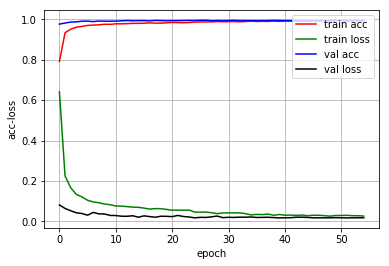

In [16]:
loss_history.loss_plot('epoch')

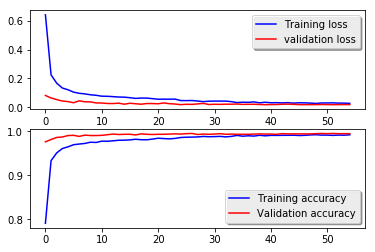

In [17]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [18]:
# Look at confusion matrix 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


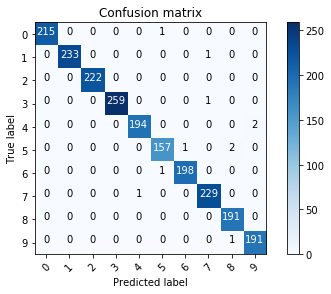

In [19]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [20]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\n True label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

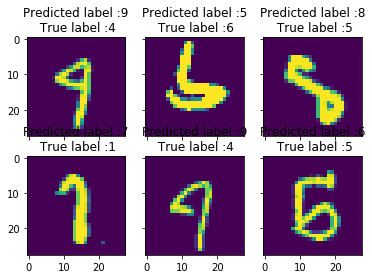

In [21]:

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]



# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [22]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

#results = pd.Series(results,name="Label")

In [23]:
submission = pd.DataFrame(data = {'ImageId':(np.arange(len(test))+1), 'Label': results})
submission.to_csv('digit_recognizer_submission.csv',index=False)

In [ ]:
# submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
# submission.to_csv("digit_recognizer_submission.csv",index=False)